<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-23_22_10_54.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [112]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [113]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [114]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [115]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [116]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [117]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [118]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [119]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [120]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 25

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [121]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters())

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [122]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.8127, Loss:  0.0033
Epoch	2	Acc:  0.8910, Loss:  0.0017
Epoch	3	Acc:  0.9036, Loss:  0.0014
Epoch	4	Acc:  0.9105, Loss:  0.0013
Epoch	5	Acc:  0.9144, Loss:  0.0012
Epoch	6	Acc:  0.9175, Loss:  0.0012
Epoch	7	Acc:  0.9191, Loss:  0.0011
Epoch	8	Acc:  0.9205, Loss:  0.0011
Epoch	9	Acc:  0.9220, Loss:  0.0011
Epoch	10	Acc:  0.9232, Loss:  0.0011
Task 0 Acc:  0.9249, Loss:  0.0011
Task 1 Acc:  0.1369, Loss:  0.0262

Task 1 Start!
Epoch	1	Acc:  0.3304, Loss:  0.0133
Epoch	2	Acc:  0.5777, Loss:  0.0077
Epoch	3	Acc:  0.6372, Loss:  0.0068
Epoch	4	Acc:  0.6645, Loss:  0.0063
Epoch	5	Acc:  0.6795, Loss:  0.0061
Epoch	6	Acc:  0.6878, Loss:  0.0059
Epoch	7	Acc:  0.6937, Loss:  0.0058
Epoch	8	Acc:  0.6981, Loss:  0.0058
Epoch	9	Acc:  0.7012, Loss:  0.0057
Epoch	10	Acc:  0.7029, Loss:  0.0057
Task 0 Acc:  0.7526, Loss:  0.0033
Task 1 Acc:  0.7092, Loss:  0.0037



 - Task 0

Accuracy 0.7526
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.88      0.82      0.85       980
     1 - one       0.96      0.80      0.88      1135
     2 - two       0.58      0.73      0.65      1032
   3 - three       0.70      0.81      0.75      1010
    4 - four       0.58      0.83      0.69       982
    5 - five       0.82      0.35      0.49       892
     6 - six       0.77      0.89      0.82       958
   7 - seven       0.94      0.83      0.88      1028
   8 - eight       0.71      0.63      0.67       974
    9 - nine       0.78      0.80      0.79      1009

    accuracy                           0.75     10000
   macro avg       0.77      0.75      0.75     10000
weighted avg       0.77      0.75      0.75     10000



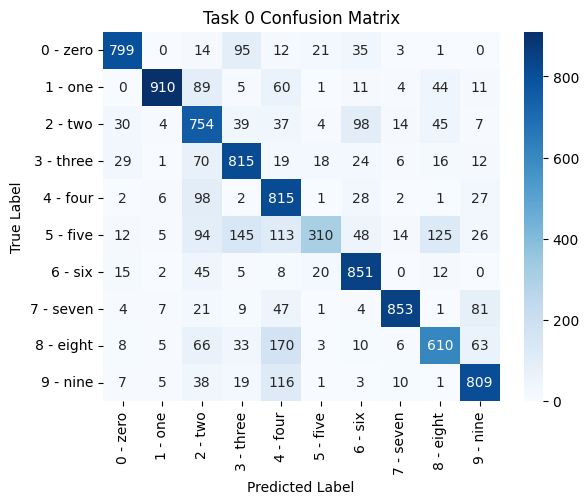

In [123]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.7092
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.80      0.85      0.83       980
     1 - one       0.89      0.95      0.92      1135
     2 - two       0.74      0.66      0.70      1032
   3 - three       0.59      0.63      0.61      1010
    4 - four       0.63      0.58      0.61       982
    5 - five       0.56      0.42      0.48       892
     6 - six       0.86      0.84      0.85       958
   7 - seven       0.70      0.78      0.74      1028
   8 - eight       0.54      0.57      0.55       974
    9 - nine       0.70      0.74      0.72      1009

    accuracy                           0.71     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.71      0.71      0.71     10000



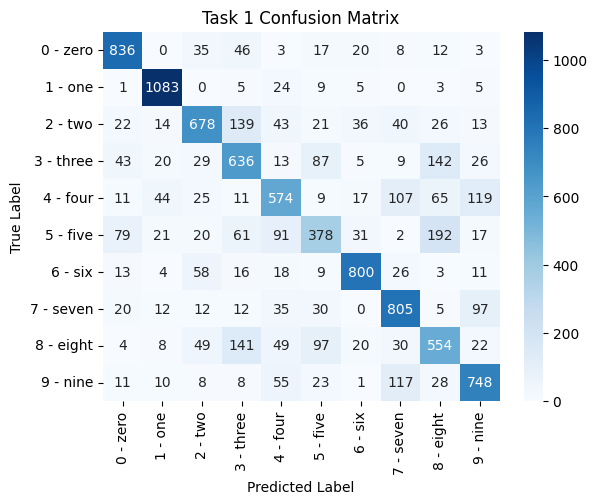

In [124]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.01225 and it's parameter diff is 0.00386
Min Parameter diff is 0.82059 and it's fisher is 0.00000
fisher > parameter diff: 100
fisher <= parameter diff: 684


<Figure size 640x480 with 0 Axes>

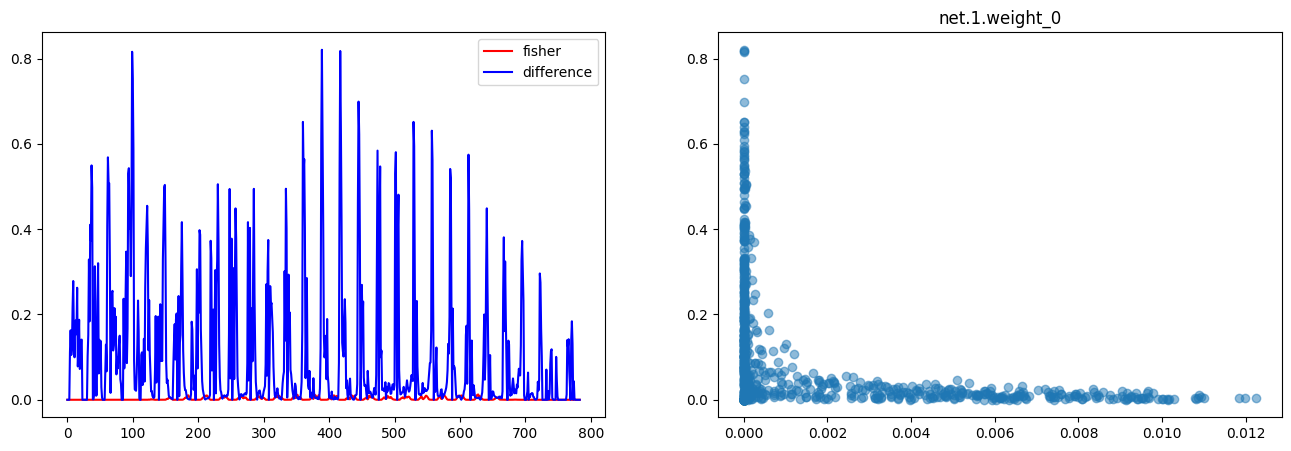

Max fisher is 0.01748 and it's parameter diff is 0.00276
Min Parameter diff is 0.93226 and it's fisher is 0.00000
fisher > parameter diff: 43
fisher <= parameter diff: 741


<Figure size 640x480 with 0 Axes>

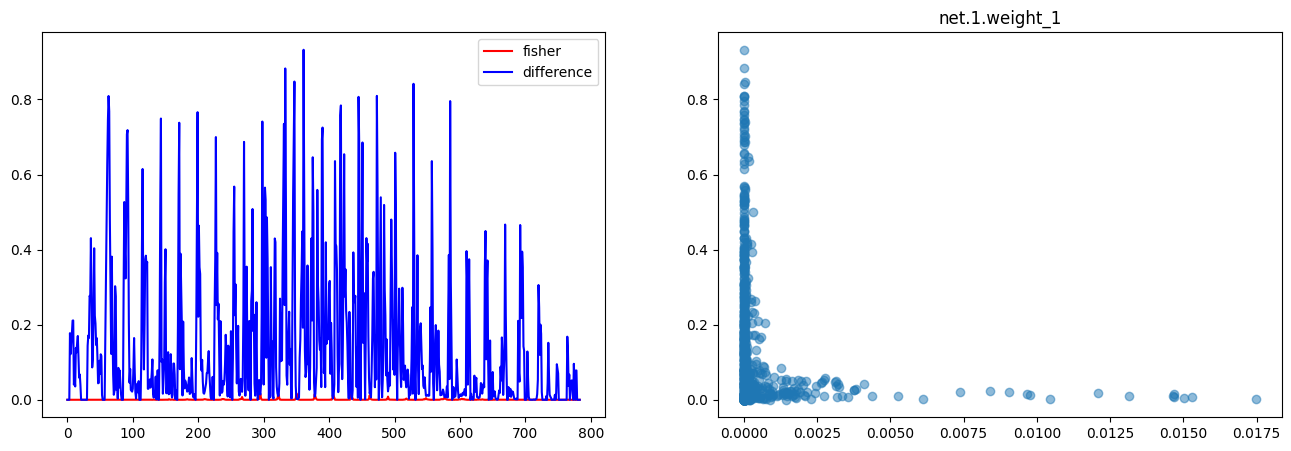

Max fisher is 0.00895 and it's parameter diff is 0.00295
Min Parameter diff is 1.12064 and it's fisher is 0.00005
fisher > parameter diff: 52
fisher <= parameter diff: 732


<Figure size 640x480 with 0 Axes>

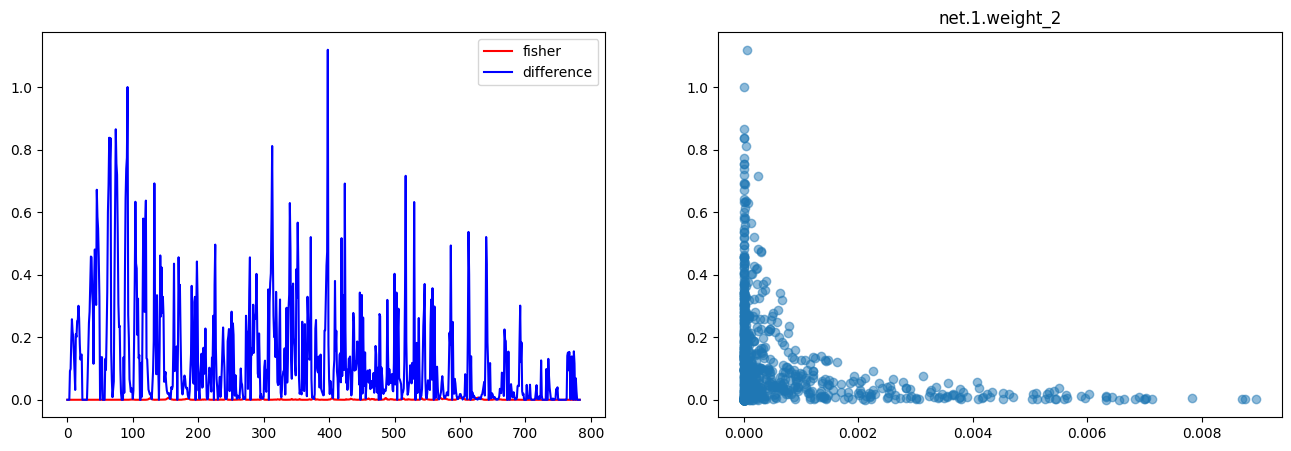

Max fisher is 0.12530 and it's parameter diff is 0.00132
Min Parameter diff is 1.06023 and it's fisher is 0.00001
fisher > parameter diff: 244
fisher <= parameter diff: 540


<Figure size 640x480 with 0 Axes>

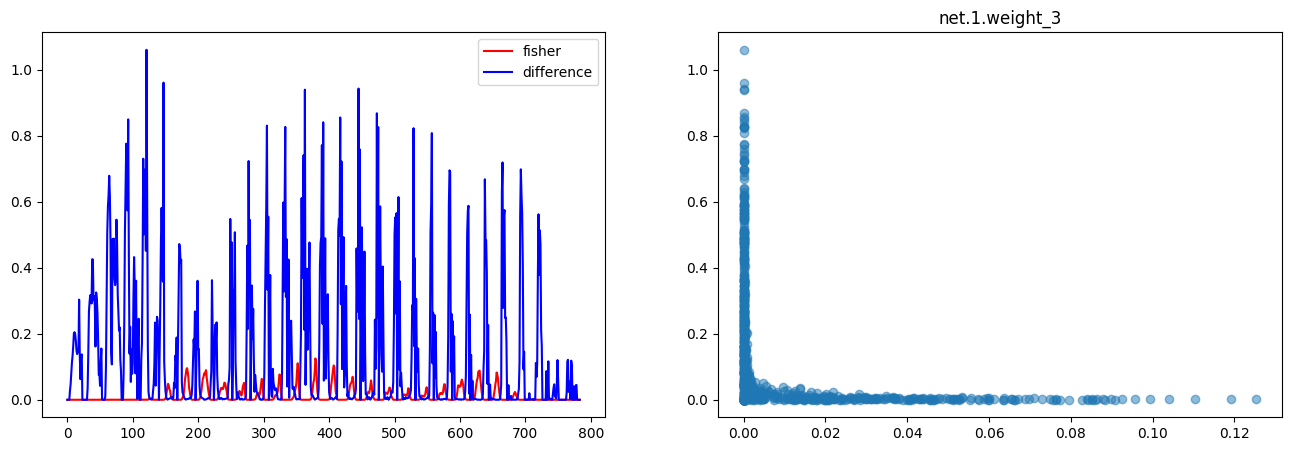

Max fisher is 0.01708 and it's parameter diff is 0.00195
Min Parameter diff is 1.02126 and it's fisher is 0.00000
fisher > parameter diff: 75
fisher <= parameter diff: 709


<Figure size 640x480 with 0 Axes>

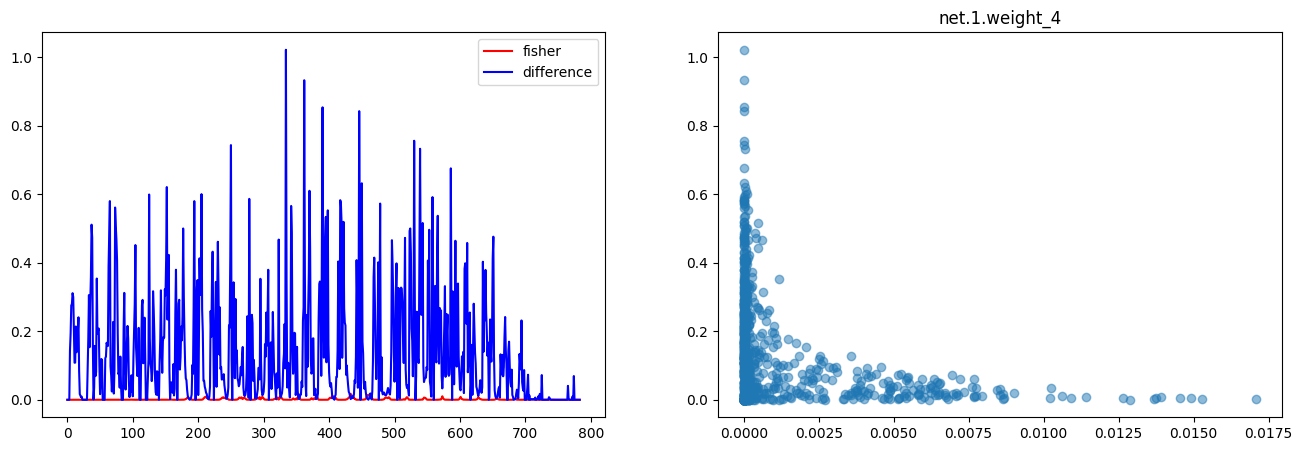

Max fisher is 0.02132 and it's parameter diff is 0.00040
Min Parameter diff is 1.20702 and it's fisher is 0.00000
fisher > parameter diff: 69
fisher <= parameter diff: 715


<Figure size 640x480 with 0 Axes>

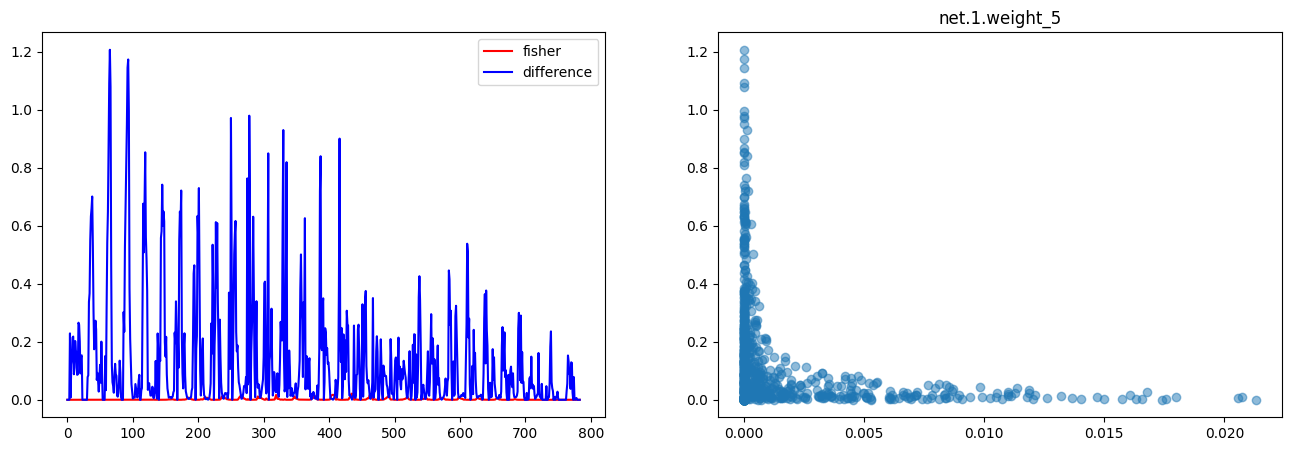

Max fisher is 0.00417 and it's parameter diff is 0.01095
Min Parameter diff is 0.92631 and it's fisher is 0.00000
fisher > parameter diff: 32
fisher <= parameter diff: 752


<Figure size 640x480 with 0 Axes>

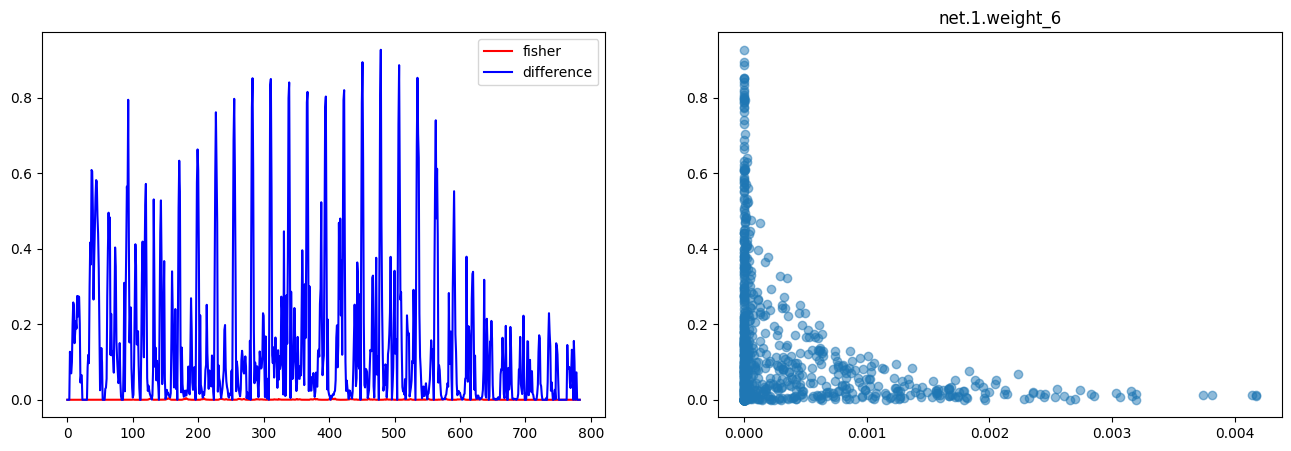

Max fisher is 0.06183 and it's parameter diff is 0.00360
Min Parameter diff is 1.18239 and it's fisher is 0.00000
fisher > parameter diff: 176
fisher <= parameter diff: 608


<Figure size 640x480 with 0 Axes>

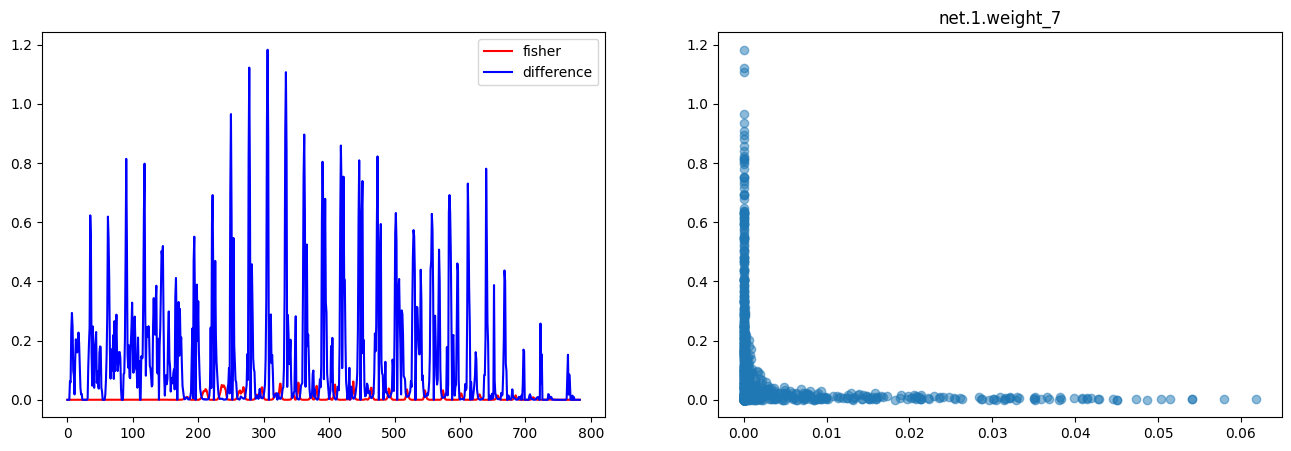

Max fisher is 0.16232 and it's parameter diff is 0.00157
Min Parameter diff is 0.91751 and it's fisher is 0.00001
fisher > parameter diff: 277
fisher <= parameter diff: 507


<Figure size 640x480 with 0 Axes>

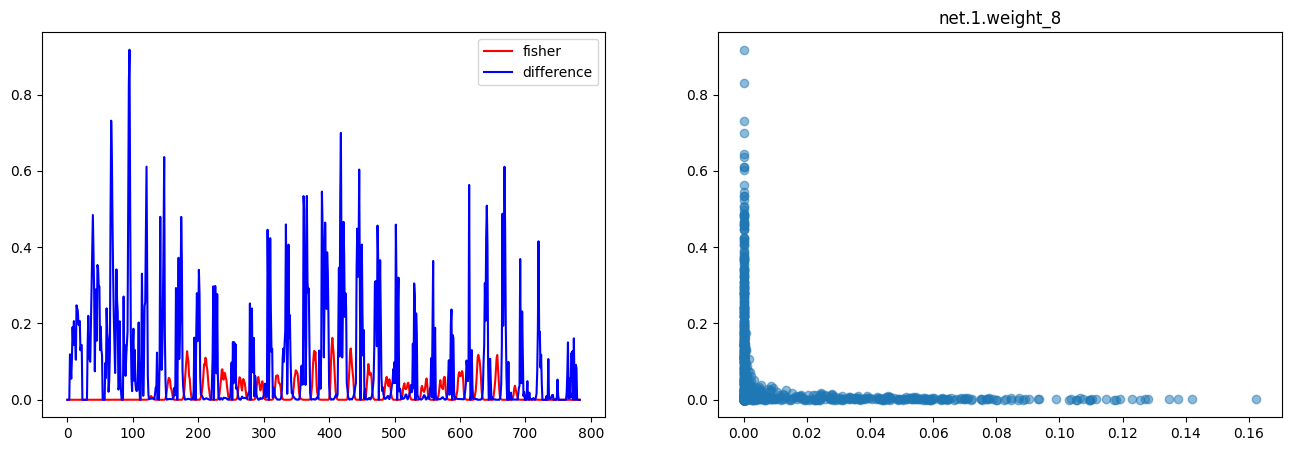

Max fisher is 0.00927 and it's parameter diff is 0.00244
Min Parameter diff is 1.08581 and it's fisher is 0.00001
fisher > parameter diff: 56
fisher <= parameter diff: 728


<Figure size 640x480 with 0 Axes>

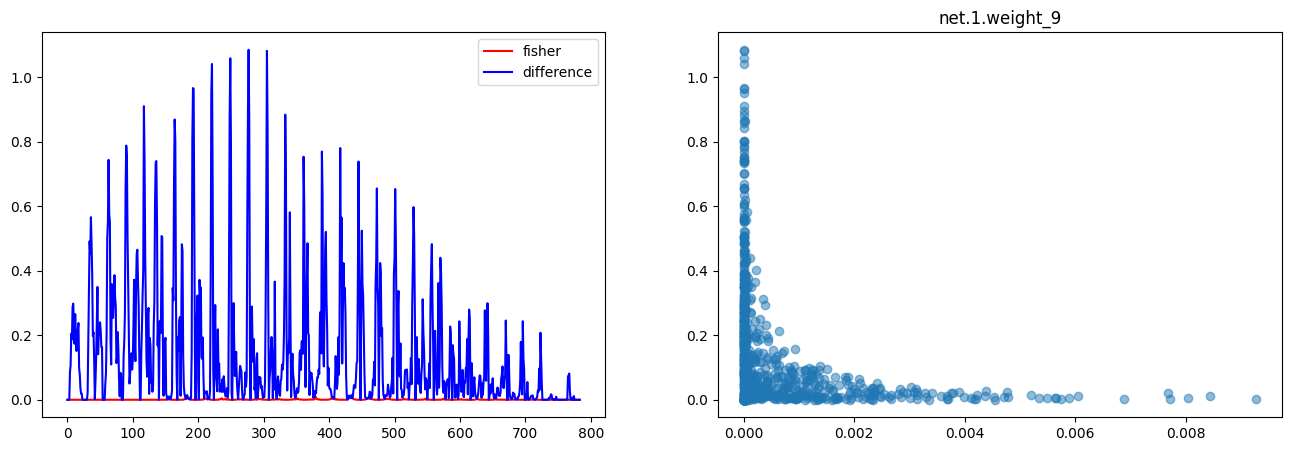


net.1.bias
torch.Size([10])
Max fisher is 0.27573 and it's parameter diff is 0.00015
Min Parameter diff is 0.01431 and it's fisher is 0.00266
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

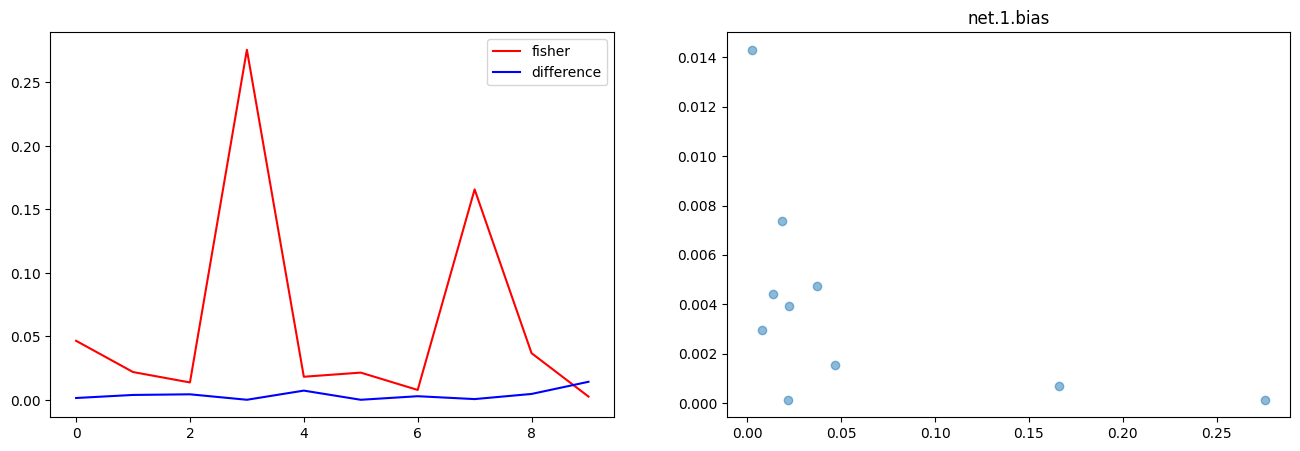

In [125]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [126]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-23_22_10_54
